<a href="https://colab.research.google.com/github/nmningmei/Deep_learning_fMRI_EEG/blob/master/10_3_searchlight_RSA_computer_vision_VGGNet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Download data

In [1]:
try:
    !git clone https://github.com/nmningmei/METASEMA_encoding_model.git
except Exception:
    pass

fatal: destination path 'METASEMA_encoding_model' already exists and is not an empty directory.


# Import necessary python liraries

In [2]:
import os

from glob import glob
from tqdm import tqdm

import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf

from matplotlib import pyplot as plt
from PIL import Image
from IPython import display

from scipy.spatial import distance
from nibabel import load as load_fmri
from scipy.stats import spearmanr

try:
    from nilearn.input_data import NiftiMasker
    from nilearn.image import new_img_like
    from brainiak.searchlight.searchlight import Searchlight
    from brainiak.searchlight.searchlight import Ball
except:
    !pip install nilearn
    !python3 -m pip install -U brainiak
    from nilearn.input_data import NiftiMasker
    from nilearn.image import new_img_like
    from nilearn.image import resample_to_img
    from nilearn import plotting
    from nilearn.datasets import load_mni152_template
    from brainiak.searchlight.searchlight import Searchlight
    from brainiak.searchlight.searchlight import Ball

sns.set_context('poster')
sns.set_style('white')

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


# Load and inspect the data: BOLD signals and events

## concatenetate data from different sessions

In [3]:
condition = 'reenact'
data_dir = 'METASEMA_encoding_model/scripts/raw/'
image_dir = 'METASEMA_encoding_model/figures/image used for computer vision model feature extraction'
bold_files = np.sort(glob(os.path.join(data_dir,'*','*.npy')))
csv_files = np.sort(glob(os.path.join(data_dir,'*','*.csv')))
example_func = os.path.join(data_dir,'example_func.nii.gz')
mask_img = os.path.join(data_dir,'mask.nii.gz')
words = os.path.join(data_dir,'word.npy')
images = glob(os.path.join(image_dir,'*','*','*.jpg'))

bold_data,csv_data = [],[]
# this is how we convert vectorized BOLD signals back to 3D volumes
masker = NiftiMasker(mask_img=mask_img,).fit(example_func)

for bold_file,csv_file in zip(bold_files,csv_files):
    temp_bold = np.load(bold_file)
    temp_csv = pd.read_csv(csv_file)

    bold_data.append(temp_bold)
    csv_data.append(temp_csv)
bold_data = np.concatenate(bold_data)
csv_data = pd.concat(csv_data)
_idx = csv_data['context'] == condition
bold_data = bold_data[_idx]
csv_data = csv_data.loc[_idx,:].reset_index()

whole_brain_data = masker.inverse_transform(bold_data)

words = np.load(words).astype(str)

# In the experiment, we did not show any images to the subject, but in the "reenact" condition, we asked the subject to "imagine" the features that are associated to the word presented on the screen. So, we sample 10 images from Google Image randomly for each word.

## Here is one of the examples

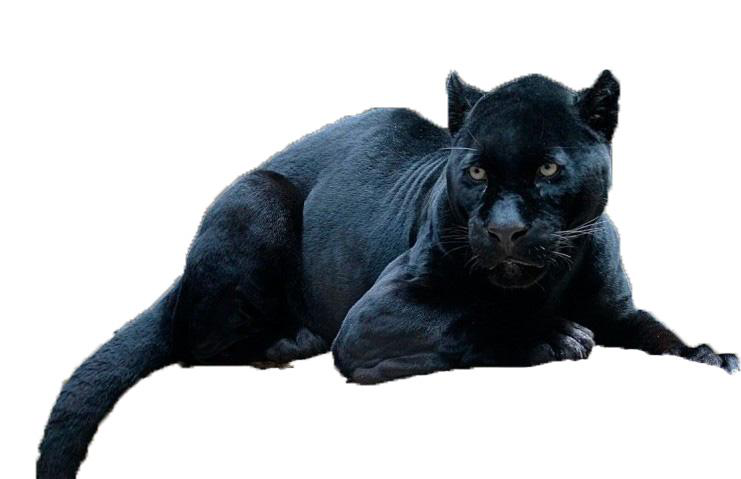

In [4]:
Image.open('METASEMA_encoding_model/figures/image used for computer vision model feature extraction/Living_Things/Pantera/pantera2.jpg',)

## Now, we need to convert a computer vision model to extract "features" from the images. The model we choose is VGG-net

In [5]:
display.Image(url = 'https://neurohive.io/wp-content/uploads/2018/11/vgg16-1-e1542731207177.png')

### define the aspects of the feature extraction process

In [6]:
train_root              = 'METASEMA_encoding_model/figures/image used for computer vision model feature extraction'
valid_root              = 'METASEMA_encoding_model/figures/image used for computer vision model feature extraction'
print_train             = True #
image_resize            = 128
batch_size              = 8
lr                      = 1e-3
n_epochs                = int(1e3)
pretrain_model_name     = 'vgg19'
hidden_units            = 2
hidden_func_name        = 'relu'
hidden_dropout          = 0.
patience                = 5
output_activation       = 'softmax'
model_saving_name       = 'temp'
output_units            = 2
categorical             = True

### The callback function, one of the key steps

In [7]:
def make_CallBackList(model_name,monitor='val_loss',mode='min',verbose=0,min_delta=1e-4,patience=50,frequency = 1):
    from tensorflow.keras.callbacks             import ModelCheckpoint,EarlyStopping
    """
    Make call back function lists for the keras models
    
    Parameters
    -------------------------
    model_name : str,
        directory of where we want to save the model and its name
    monitor : str, default = 'val_loss'
        the criterion we used for saving or stopping the model
    mode : str, default = 'min'
        min --> lower the better, max --> higher the better
    verboser : int or bool, default = 0
        printout the monitoring messages
    min_delta : float, default = 1e-4
        minimum change for early stopping
    patience : int, default = 50
        temporal windows of the minimum change monitoring
    frequency : int, default = 1
        temporal window steps of the minimum change monitoring
    
    Return
    --------------------------
    CheckPoint : tensorflow.keras.callbacks
        saving the best model
    EarlyStopping : tensorflow.keras.callbacks
        early stoppi
    """
    checkPoint = ModelCheckpoint(model_name,# saving path
                                 monitor          = monitor,# saving criterion
                                 save_best_only   = True,# save only the best model
                                 mode             = mode,# saving criterion
                                 verbose          = verbose,# print out (>1) or not (0)
                                 )
    earlyStop = EarlyStopping(   monitor          = monitor,
                                 min_delta        = min_delta,
                                 patience         = patience,
                                 verbose          = verbose, 
                                 mode             = mode,
                                 )
    return [checkPoint,earlyStop]

### construct the computer vision and fine the model for our experiment

In [8]:
# load the pretrained model and remove the dense layers (blue parts in the image above)
pretrained_model = tf.keras.applications.VGG19(weights     = 'imagenet',
                                               include_top = False, # remove the blue parts of the model showed above
                                               input_shape = (image_resize,image_resize,3),
                                               )
# image preprocessing function that was used for training the computer vision model
preprocess_input = tf.keras.applications.vgg19.preprocess_input
# freeze the pretrained model so that we do not modify it accidentally
for layer in pretrained_model.layers:
    layer.trainable = False

# the data flow function that feeds images to the computer vision model
gen             = tf.keras.preprocessing.image.ImageDataGenerator(
                                     rotation_range         = 90,               # allow rotation
                                     width_shift_range      = 0.1,              # horizontal schetch
                                     height_shift_range     = 0.1,              # vertical schetch
                                     zoom_range             = 0.1,              # zoom in
                                     horizontal_flip        = True,             # 
                                     vertical_flip          = True,             # 
                                     preprocessing_function = preprocess_input, # scaling function (-1,1)
                                     validation_split       = 0.1,
                                     )
gen_train       = gen.flow_from_directory(train_root,
                                            target_size       = (image_resize,image_resize),  # resize the image
                                            batch_size        = batch_size,                   # batch size
                                            class_mode        = 'categorical',                # get the labels from the folders
                                            shuffle           = True,                         # shuffle for different epochs
                                            seed              = 12345,                        # replication purpose
                                            subset            = 'training',
                                            )
gen_valid       = gen.flow_from_directory(valid_root,
                                            target_size       = (image_resize,image_resize),  # resize the image
                                            batch_size        = batch_size,                   # batch size
                                            class_mode        = 'categorical',                # get the labels from the folders
                                            shuffle           = True,                         # shuffle for different epochs
                                            seed              = 12345,                        # replication purpose
                                            subset            = 'validation',
                                            )
# we stack more layers on to the pretrained model to make a classifier so that we can fine-tune the model
fine_tune_model = pretrained_model.output
fine_tune_model = tf.keras.layers.GlobalAveragePooling2D(name = 'Globalave')(fine_tune_model)
r = tf.keras.models.Model(pretrained_model.inputs,fine_tune_model)
hidden_layer = tf.keras.layers.Dense(300, # <- so we can compate the computer vision to the word-embedding model
                                   activation                       = tf.keras.activations.selu, # SOTA activation function
                                   kernel_initializer               = 'lecun_normal', # seggested in documentation
                                   kernel_regularizer               = tf.keras.regularizers.l2(), # control for model weights
                                   activity_regularizer             = tf.keras.regularizers.l1(), # control for activation, aim to prompt sparsity
                                   name                             = 'feature'
                                   )(fine_tune_model)
fine_tune_model = tf.keras.layers.Dense(len(gen_train.class_indices),
                                   activation                       = 'softmax',
                                   kernel_regularizer               = tf.keras.regularizers.l2(),
                                   activity_regularizer             = tf.keras.regularizers.l1(),
                                   name                             = 'predict'
                                   )(hidden_layer)
clf             = tf.keras.models.Model(pretrained_model.inputs,fine_tune_model)
print(clf.summary())
# compile the model with an optimizer, a loss function
clf.compile(tf.keras.optimizers.Adam(lr = lr,),
            tf.keras.losses.categorical_crossentropy,
            metrics = ['categorical_accuracy'])
# define the feature extractor
feature_extractor = tf.keras.models.Model(pretrained_model.inputs,clf.layers[-2].output)

Found 324 images belonging to 2 classes.
Found 36 images belonging to 2 classes.
Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 128, 128, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 128, 128, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 128, 128, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 64, 64, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 64, 64, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 64, 64, 128)       147584    
____________________________________________

### Before we fine-tune the model, we extract the features from each image and then we average those belonging to the same word

In [9]:
targets,unique_words,features = [],[],[]
for image_name in tqdm(images,desc='before fine-tuning'):
    _,_,_,target,unique_word,_ = image_name.split('/')
    image_loaded        = tf.keras.preprocessing.image.load_img(image_name,target_size = (image_resize,image_resize,3))
    image_data          = preprocess_input(tf.keras.preprocessing.image.img_to_array(image_loaded)[np.newaxis,])
    feature_            = feature_extractor.predict(image_data)
    targets.append(target)
    unique_words.append(unique_word.lower())
    features.append(feature_[0])
df_temp = pd.DataFrame(np.vstack([targets,unique_words]).T,columns = ['targets','words'])
features = np.array(features)

before fine-tuning: 100%|██████████| 324/324 [00:14<00:00, 22.02it/s]


In [10]:
temp = {}
for unique_word,df_sub in df_temp.groupby(['words']):
    features_ = features[df_sub.index]
    temp[unique_word] = features_.mean(0)
img2vec_no_tune = pd.DataFrame.from_dict(temp)

### now, let's fine-tune the model and extract the features again

In [11]:
callbacks           = make_CallBackList('temp.h5',
                                        monitor                 = 'val_loss',
                                        mode                    = 'min',
                                        verbose                 = 0,
                                        min_delta               = 1e-4,
                                        patience                = 2,
                                        frequency               = 1)
clf.fit(gen_train,
        steps_per_epoch                           = np.ceil(gen_train.n / batch_size),
        epochs                                    = 1000, # arbitrary choice
        validation_data                           = gen_valid,
        callbacks                                 = callbacks,
        )
del clf


Epoch 1/1000
41/41 [==============================] - 6s 116ms/step - loss: 12.5034 - categorical_accuracy: 0.8720 - val_loss: 8.6819 - val_categorical_accuracy: 0.7778
Epoch 2/1000
41/41 [==============================] - 4s 93ms/step - loss: 8.0792 - categorical_accuracy: 0.9678 - val_loss: 7.5038 - val_categorical_accuracy: 0.9722
Epoch 3/1000
41/41 [==============================] - 4s 93ms/step - loss: 7.3779 - categorical_accuracy: 0.9981 - val_loss: 7.2190 - val_categorical_accuracy: 0.9722
Epoch 4/1000
41/41 [==============================] - 4s 93ms/step - loss: 7.0153 - categorical_accuracy: 1.0000 - val_loss: 6.7879 - val_categorical_accuracy: 0.9444
Epoch 5/1000
41/41 [==============================] - 4s 89ms/step - loss: 6.6632 - categorical_accuracy: 1.0000 - val_loss: 6.5371 - val_categorical_accuracy: 0.9444
Epoch 6/1000
41/41 [==============================] - 4s 96ms/step - loss: 6.3071 - categorical_accuracy: 0.9997 - val_loss: 6.1552 - val_categorical_accuracy: 0.9

In [12]:
clf = tf.keras.models.load_model('temp.h5')
for layers in clf.layers:
    layers.trainable = False
# define the feature extractor
feature_extractor = tf.keras.models.Model(clf.inputs,clf.layers[-2].output)

In [13]:
targets,unique_words,features = [],[],[]
for image_name in tqdm(images,desc='after fine-tuning'):
    _,_,_,target,unique_word,_ = image_name.split('/')
    image_loaded        = tf.keras.preprocessing.image.load_img(image_name,target_size = (image_resize,image_resize,3))
    image_data          = preprocess_input(tf.keras.preprocessing.image.img_to_array(image_loaded)[np.newaxis,])
    feature_            = feature_extractor.predict(image_data)
    targets.append(target)
    unique_words.append(unique_word.lower())
    features.append(feature_[0])
df_temp = pd.DataFrame(np.vstack([targets,unique_words]).T,columns = ['targets','words'])
features = np.array(features)

after fine-tuning: 100%|██████████| 324/324 [00:13<00:00, 24.24it/s]


In [14]:
temp = {}
for unique_word,df_sub in df_temp.groupby(['words']):
    features_ = features[df_sub.index]
    temp[unique_word] = features_.mean(0)
img2vec_fine_tune = pd.DataFrame.from_dict(temp)

## Plot the computer vision model of the 36 unique words - before fine tuning

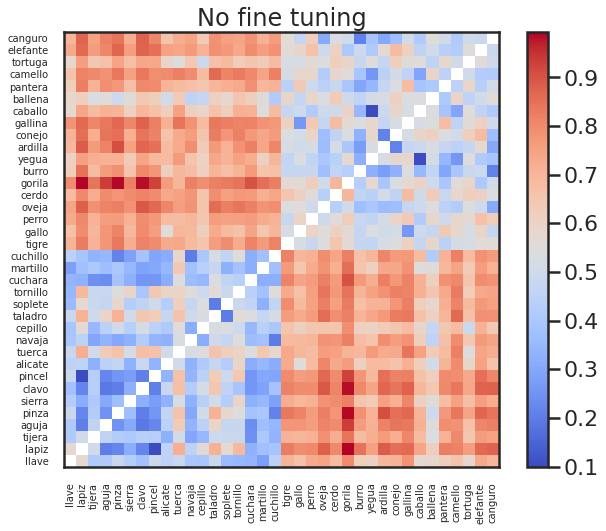

In [15]:
df_plot = img2vec_no_tune[words]
corr = distance.squareform(distance.pdist(df_plot.values.T,'correlation'))
np.fill_diagonal(corr,np.nan)
fig,ax = plt.subplots(figsize = (10,8))
im = ax.imshow(corr,
               origin = 'lower',
               cmap = plt.cm.coolwarm,
               )
plt.colorbar(im)
ax.set(yticks = np.arange(36),xticks = np.arange(36),title = 'No fine tuning')
_=ax.set_yticklabels(words,fontsize = 10,)
_=ax.set_xticklabels(words,fontsize = 10,rotation = 90)

## Plot the computer vision model of the 36 unique words - after fine tuning

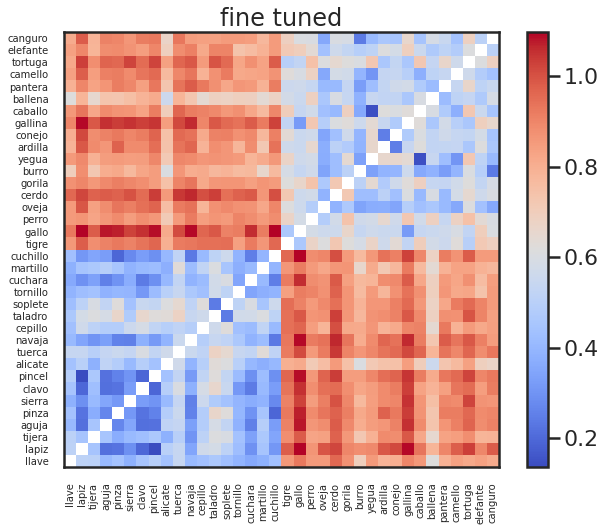

In [16]:
df_plot = img2vec_fine_tune[words]
corr = distance.squareform(distance.pdist(df_plot.values.T,'correlation'))
np.fill_diagonal(corr,np.nan)
fig,ax = plt.subplots(figsize = (10,8))
im = ax.imshow(corr,
               origin = 'lower',
               cmap = plt.cm.coolwarm,
               )
plt.colorbar(im)
ax.set(yticks = np.arange(36),xticks = np.arange(36),title = 'fine tuned')
_=ax.set_yticklabels(words,fontsize = 10,)
_=ax.set_xticklabels(words,fontsize = 10,rotation = 90)

## Helper functions

In [17]:
def normalize(data,axis = 1):
    return data - data.mean(axis).reshape(-1,1)
# Define voxel function
def sfn(l, msk, myrad, bcast_var):
    """
    l: BOLD
    msk: mask array
    myrad: not use
    bcast_var: word embedding model
    """
    BOLD = l[0][msk,:].T.copy() # vectorize the voxel values in the sphere
    #print(BOLD.shape) # <- for debugging
    model = bcast_var.copy() # vectorize the RDM
    #print(model.shape) # <- for debugging
    # pearson correlation
    RDM_X   = distance.pdist(normalize(BOLD),'correlation')
    RDM_y   = distance.pdist(normalize(model),'correlation')
    D,p     = spearmanr(RDM_X,RDM_y)
    return D

## Prepare the whole brain BOLD signals that are averaged from all the sessions

In [18]:
bold_average,word_average = [],[]
for _word, df_sub in csv_data.groupby(['words']):
    temp = bold_data[df_sub.index]
    bold_average.append(temp.mean(0))
    word_average.append(_word.lower())
bold_average = np.vstack(bold_average)
bold_average.shape

whole_brain_average = masker.inverse_transform(bold_average)
BOLD_image = np.asanyarray(whole_brain_average.dataobj)
print(BOLD_image.shape)

(88, 88, 66, 36)


# Searchlight RSA

## hyperparameters - not important

In [19]:
radius = 6 # in mm

### This is going to take some time to run - 1 fold - for the average of the BOLD signals

In [20]:
df_plot = img2vec_no_tune[words]
# Brainiak function
sl = Searchlight(sl_rad = radius, 
                max_blk_edge = radius - 1, 
                shape = Ball,
                min_active_voxels_proportion = 0,
                )
# distribute the data based on the sphere
## the first input is usually the BOLD signal, and it is in the form of 
## lists not arrays, representing each subject
## the second input is usually the mask, and it is in the form of array
sl.distribute([BOLD_image],np.asanyarray(load_fmri(mask_img).dataobj) == 1)
# broadcasted data is the data that remains the same during RSA
sl.broadcast(df_plot[word_average].values.T)
# run searchlight algorithm
global_outputs_no_tune = sl.run_searchlight(sfn,
                                            pool_size = -1, # we run each RSA using a single CPU
                                            )

In [21]:
df_plot = img2vec_fine_tune[words]
# Brainiak function
sl = Searchlight(sl_rad = radius, 
                max_blk_edge = radius - 1, 
                shape = Ball,
                min_active_voxels_proportion = 0,
                )
# distribute the data based on the sphere
## the first input is usually the BOLD signal, and it is in the form of 
## lists not arrays, representing each subject
## the second input is usually the mask, and it is in the form of array
sl.distribute([BOLD_image],np.asanyarray(load_fmri(mask_img).dataobj) == 1)
# broadcasted data is the data that remains the same during RSA
sl.broadcast(df_plot[word_average].values.T)
# run searchlight algorithm
global_outputs_fine_tune = sl.run_searchlight(sfn,
                                                pool_size = -1, # we run each RSA using a single CPU
                                                )

## Convert the numpy array to Nifti

In [22]:
correlations_no_tune = new_img_like(example_func,np.asanyarray(global_outputs_no_tune,dtype = np.float32))
# masking
correlations_no_tune = masker.inverse_transform(masker.transform_single_imgs(correlations_no_tune))

correlations_fine_tune = new_img_like(example_func,np.asanyarray(global_outputs_fine_tune,dtype = np.float32))
# masking
correlations_fine_tune = masker.inverse_transform(masker.transform_single_imgs(correlations_fine_tune))

## Visualization

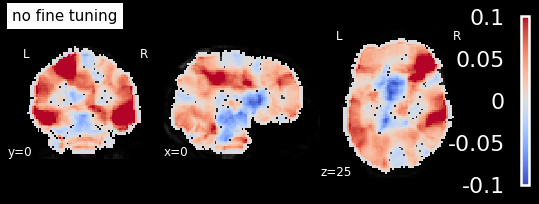

In [30]:
plotting.plot_stat_map(correlations_no_tune,
                       example_func,
                       threshold = 1e-3,
                       draw_cross = False,
                       cmap = plt.cm.coolwarm,
                       vmax = .1,
                       title = 'no fine tuning',
                       cut_coords = [0,0,25],
                       )

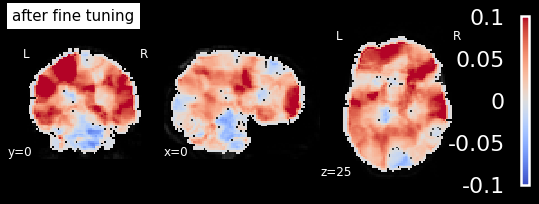

In [31]:
plotting.plot_stat_map(correlations_fine_tune,
                       example_func,
                       threshold = 1e-3,
                       draw_cross = False,
                       cmap = plt.cm.coolwarm,
                       vmax = .1,
                       title = 'after fine tuning',
                       cut_coords = [0,0,25],
                       )